# preprocessing
Ideally, this notebook will include a demo of preprocessing steps for some participants, artefact detection and quality control analysis.
The preprocessing steps layed out here will be run for all the participants at once by bids-mne-pipline.
preprocessing steps includes:
1. bad channels detection (this step will be endorsed by topographical maps as well)
2. highpass filter (0.3) maybe I can compare the effect of filters, for example, if I apply a highpass filter but no low-pass filter does it affect the end result considering that my downstream task is time-frequency analysis so I will apply filtering at the end anyway?
2. delete the bad parts
3. artefact detection
4. Autoreject.


## Setup

In [1]:
# Import necessary modules
import mne
import pandas as pd
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
import mne_bids
from pathlib import Path

## open data, bad channel detection (topographical), re-reference, highpass filter

### open bids data

In [3]:
subject='01'
session = '01'
task = 'baseline1'
bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)

raw = mne_bids.read_raw_bids(bids_path, verbose=False)                

Extracting parameters from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_events.tsv.
Reading channel info from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-01/ses-01/eeg/sub-01_ses-01_task-baseline1_channels.tsv.


### re-refrencing
In this part, we will visualize the effect of re-referencing for those with noisy mastoeids.


As an instance of the effect of changing the reference, we also see its effect on the frontal channels (uncomment the line of setting eeg reference to see the effect):

Extracting parameters from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Reading events from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_events.tsv.
Reading channel info from /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_channels.tsv.
Effective window size : 2.048 (s)


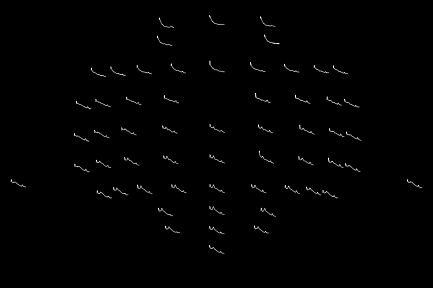

In [82]:
subject='02'
session = '01'
task = 'baseline1'
bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)

raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False)
# raw.add_reference_channels(ref_channels = 'FCz') # is it for adding the reference channel to the data?
# raw.set_eeg_reference(ref_channels=['M1','M2'])

pos = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(pos)
raw. plot_psd_topo(fmin=0, fmax=40)
plt.show()  

### Bad channels detections
As it was explained in the "topographical map" video, here we want to use topographical maps to validate the detected bad channels.

Extracting parameters from data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 333580  =      0.000 ...   333.580 secs...
Reading events from data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_events.tsv.
Reading channel info from data/Main-study/sub-02/ses-01/eeg/sub-02_ses-01_task-baseline1_channels.tsv.
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


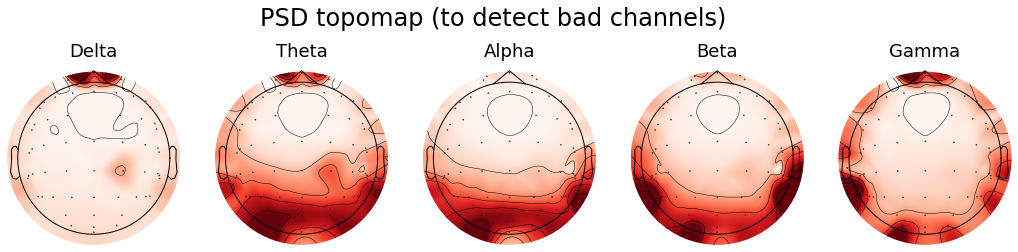

In [3]:
# open and test raw data for each subject at different tasks
subject='02'
session = '01'
task = 'baseline1'
# bids_root = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study'
bids_root = Path('data/Main-study')
if not bids_root.exists():
    raise Exception('Not found')

bids_path = mne_bids.BIDSPath(subject=subject, session=session, task=task, root=bids_root)
raw = mne_bids.read_raw_bids(bids_path, extra_params={'preload':True}, verbose=False)
raw.drop_channels(['EOG1','EOG2','ECG']) # only eeg channels
# set montage
pos = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(pos)
pos = raw.get_montage() # we should re-get the digitized point after we set the new montage,
                        # because originally there are 94 channela in the standard montage,
                        # and we only need the coordinations of 58 of them

# pos is an object of DigMontage type, instead we need a 2D array of XY channel postions,
# the following will do that
ch_pos = np.array(list(pos.get_positions()['ch_pos'].values())) 
ch_pos = ch_pos[:,0:2]

# creat a dictionary of the frequency bands with their lower and upper bounds
keys = ['Delta','Theta', 'Alpha', 'Beta', 'Gamma']
bounds = [(0,4), (4,8), (8,12), (12,30), (30,45)]
bands = dict(zip(keys, bounds))

fig, axes = plt.subplots(1, len(bands), sharex= True, figsize=(18,3.5))
for i,key in enumerate(bands.keys()):
    psds = mne.time_frequency.psd_welch(raw, fmin=bands[key][0], fmax=bands[key][1], picks=['eeg'], average= 'mean')
    psds_mean = psds[0].mean(axis=1)
    mne.viz.plot_topomap(psds_mean, ch_pos, axes=axes[i], show=False)
    axes[i].set_title(key, fontsize=18)

plt.suptitle('PSD topomap (to detect bad channels)', y=1.12, fontsize=24)
plt.show()

Effective window size : 2.048 (s)


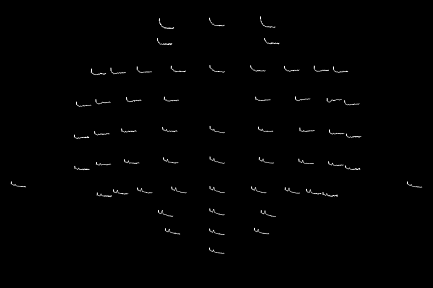

In [7]:
# first epoching the data because topographical map is possible only for epoched data
## new annotations
new_annot = mne.Annotations(onset=[0],
                         duration=[333],
                        description=['baseline1'])
raw.set_annotations(new_annot)
events, event_dict = mne.events_from_annotations(raw, chunk_duration= 1)
## epoch data
epoch = mne.Epochs(raw, events, event_dict, preload= True)

# topographical map
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')]
mne.viz.plot_epochs_psd_topomap(epoch, bands=bands, ch_type='eeg', dB=True, bandwidth=2, verbose=0)
plt.show()

### highpass filter cutoff
in the second iteration of preprocessing the cutoff of highpass filtering will be changed to 0.5. Different value of cutoffs (None, 0.3, 0.5, 1) applied to the baseline1 part of subject 01's eeg data. From the visulisation cutoff 1 could eliminate the majority of drift artefacts. If we don't want to go for a highpass as large as 1, the cutoff value of 0.5 was slightly better than 0.3, so we will choose 0.5Hz. Also, this is the value suggested by Mike X. cohen in his video about the preprocessing steps.

## delete bad parts, artefact detection

### eog artefact detections
After deleting the bad parts, according to the lenght of the audio recording, first apply a highpass filter of 1 hz, then detect eog events, because it might detect small drift as eog events.

## AutoReject
In this part, I'll apply autoreject and will compare the result with the manual rejection.